<a href="https://colab.research.google.com/github/pragati77/Detection-of-Diabetic-Retinopath-using-CNN/blob/master/Retinopracc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# here,we are importing all the libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib
from subprocess import check_output
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D,GlobalAveragePooling2D, MaxPooling2D, Dropout, Flatten, Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers

Using TensorFlow backend.


In [0]:
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

In [3]:
NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 256
HEIGHT = 256
DEPTH = 3

inputShape = (HEIGHT, WIDTH, DEPTH)
print("inputshape:")
print(inputShape)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
#global variables
ImageNameDataHash = {} #contains image names of the fundus such as right and left #curly brackets are used to indicate "dictionary" in python
uniquePatientIDList = [] #square bracket indicates that it is LIST.

inputshape:
(256, 256, 3)


In [5]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
 cd /content/drive/My Drive

/content/drive/My Drive


In [7]:
cd Retino

/content/drive/My Drive/Retino


In [8]:
ls

resized_train/  trainLabels.csv


In [0]:
def readTrainData(trainDir):
    global ImageNameDataHash #This is the dictionary that we derfined before.
    # loop over the input images
    images = os.listdir(trainDir) #trainDir are the images that are used to train the model
    print("Number of files in " + trainDir + " is " + str(len(images)))#this only prints the number of images i.e 2849
    #print(images)
    for imageFileName in images: #imageFilename is just a variable
        if (imageFileName == "trainLabels.csv"): #comparing with the lable names in csv file
            continue
        imageFullPath = os.path.join( trainDir, imageFileName) #it comibines 2 paths, ex :./resized_train/1269_left.jpeg
        #print(imageFullPath)
        img = load_img(imageFullPath) #img contains PIL image instance.PIL is the Python Imaging Library which provides the python interpreter with image editing capabilities(helpful for image preprocessing). 
        #print(img)

        arr = img_to_array(img) #Converts a PIL Image instance to a Numpy array.
        #print(arr)
        dim1 = arr.shape[0] #initial size of the images which are random ( initial length 683,768,618....)
        dim2 = arr.shape[1] #( initial Breadth 683,768,618....)
        dim3 = arr.shape[2] #(depth)
        #print(dim1)
        #print(dim2)
        #print(dim3)
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))

        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3) we RESIZE our fundus images here
        #print(arr.shape) # 256,256,3
        dim1 = arr.shape[0] #(new length is 256)
        dim2 = arr.shape[1] #(new width is 256)
        dim3 = arr.shape[2]
        #print(dim1)
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        #print(type(arr)) #the type of arr is numpy array.
        # scale the raw pixel intensities to the range [0, 1] 
        arr = np.array(arr, dtype="float") / 255.0 #here, we are converting into grey-scale.
        #print(arr)
        imageFileName = imageFileName.replace('.jpeg','') #string.replace(old, new) Therefore, we are removing .jpeg extension.(12460_right)
        #print(imageFileName)
        ImageNameDataHash[str(imageFileName)] = np.array(arr) #this is a dictionary of imagename(key) mapped to image which is in array format(value).
        #print( ImageNameDataHash)
    return

    

In [48]:
from datetime import datetime
print("Loading images at..."+ str(datetime.now()))
sys.stdout.flush()
readTrainData("./resized_train")
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now())) 

Loading images at...2020-02-25 16:36:16.998385
Number of files in ./resized_train is 2849
Loaded 2849 images at...2020-02-25 16:49:35.399748


In [0]:
def readTrainCsv():
  raw_df = pd.read_csv('./trainLabels.csv', sep=',')
  #print(raw_df) #it prints the image and level from the csv file
  row_count=raw_df.shape[0] #gives number of row count row_count=35126 
  col_count=raw_df.shape[1] #gives number of col count col count=2
  print("row_count="+str(row_count)+" col count="+str(col_count))
  raw_df["PatientID"] = '' #creating another column which is patientID 
  header_list = list(raw_df.columns) #stores the column names
  print(header_list) # ['image', 'level', 'PatientID']
  # double check if level of left and right are same or not
  ImageLevelHash = {} #dictionary
  patientIDList = [] #List
 # print(raw_df.iterrows) #0    10_left   0
  for index, row in raw_df.iterrows():
      # 0 is image, 1 is level, 2 is PatientID, 3 is data
      key = row[0] + ''
      #print(key) #--> 44268_right,44268_left...........
      patientID = row[0] + '' #same as key....but...........
      #print(patientID)
      patientID = patientID.replace('_right','')#............we are removing right and left too !!
      patientID = patientID.replace('_left','')#..........patientID will only contain 25802.....
      #print("Adding patient ID"+ patientID) # it will print as follows "Adding patient ID25802"
      raw_df.at[index, 'PatientID'] = patientID #under the patientID column head, we put all the patientIDs
      patientIDList.append(patientID) #appending patientID to list
      ImageLevelHash[key] = str(row[1]) # creates a dictionary where, key is image name (13_left) and value is level(0,1,2,3,4,5) Ex '15_right': '2'
      #print(ImageLevelHash)

  global uniquePatientIDList #issa list again
  uniquePatientIDList = sorted(set(patientIDList)) #list contains unique patientIDs in a sorted manner.
  count=0;
  for patientID in uniquePatientIDList:
      left_level = ImageLevelHash[str(patientID+'_left')] #records the DR level in left eye
      right_level = ImageLevelHash[str(patientID+'_right')] #records the DR level in right eye
      #right_exists = str(patientID+'_right') in raw_df.values
      if (left_level != right_level): #if the DR level in both eyes aren't the same.......
          count = count+1
          #print("Warning for patient="+ str(patientID) + " left_level=" + left_level+ " right_level=" +right_level)
  print("count of images with both left and right eye level not matching="+str(count)) # 2240
  print("number of unique patients="+str(len(uniquePatientIDList))) # 17563
  return raw_df #raw_df contains images,levels and patientIDs
 


In [69]:
random.seed(10) # :( 
print("Reading trainLabels.csv...")
df = readTrainCsv() #df contains whatever is in raw_df


Reading trainLabels.csv...
row_count=35126 col count=2
['image', 'level', 'PatientID']
count of images with both left and right eye level not matching=2240
number of unique patients=17563


In [70]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID'] # get patient id of patients..."s" contains the patient ID now
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [72]:
keepImages =  list(ImageNameDataHash.keys()) #ImageNameDataHash.keys() contains '12127_left', '12129_left', '1212_left', '1212_right'....(image names)
#print(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)] # isin() method helps in selecting rows with having a particular(or Multiple) value in a particular column.
#so...it(df) contains all the image names.
print(len(df)) # 2849 (basically the number of fundus images)

2849


In [0]:
#convert hash to dataframe
imageNameArr = [] #LIST
dataArr = [] #also LIST
for index, row in df.iterrows():
    key = str(row[0]) #--> key contains the image names (13201_right,13206_lef,13206_right,13209_left.....)
    #print(key)
    if key in ImageNameDataHash: #if key exists in ImageNameDataHash
        imageNameArr.append(key) #here, we append the key(image names) into the list. **This is the key**
        dataArr.append(np.array(ImageNameDataHash[key])) # in this list, we append the (image array) into the list **This is the value** :)


In [75]:
df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr}) #storing the image names in "image" and the image array in "data"
df2_header_list = list(df2.columns) # image and data forms 2 columns in dataframe
print(df2_header_list) # ['image', 'data']
print(len(df2)) # 2849
#print(df2.describe(include='all'))
#print(df2.sample(3)) # 3 rows x 2 columns
if len(df) != len(df2): #we make sure that all the images are added to df2 aswell.
    print("Error length of df != df2")

['image', 'data']
2849


In [78]:
print("for df2 :")
print(df2.dtypes)
print("for df :")
print(df.dtypes)

for df2 :
image    object
data     object
dtype: object
for df :
image        object
level         int64
PatientID    object
dtype: object


In [79]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer') #here, we merge both the data frames.
df_header_list = list(df.columns) 
print(df_header_list) # ['image', 'data', level', 'PatientID']
print(len(df)) #2849
print(df.sample(3))

['image', 'data', 'level', 'PatientID']
2849
            image  ... PatientID
1229  11209_right  ...     11209
1374   11392_left  ...     11392
794    10660_left  ...     10660

[3 rows x 4 columns]


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
sample shape is
(256, 256, 3)


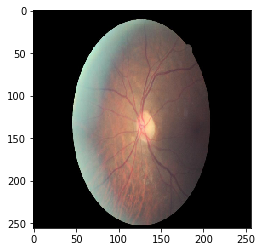

Sample Image


In [82]:
sample0 = df.loc[df.index[0], 'data'] # "data" contains image in array format
print(sample0) # array image (2D array)
#print(type(sample0)) # <class 'numpy.ndarray'>
print("sample shape is")
print(sample0.shape) # 256,256,3 
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [83]:
X = df['data'] # t h e          a r r a y             i m a g e s 
Y = df['level'] # DR levels (0,1,2,3,4,5)
Y = np.array(Y) #converting Y into array?
Y =  to_categorical(Y, num_classes=NUM_CLASSES) #binaryyy
#print(Y)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [86]:
print("Partition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique())) # 1425
unique_ids = df.PatientID.unique()
print('unique_ids ='+ str(len(unique_ids))) #1425 same thing as above

Partition data into 75:25...
Unique patients in dataframe df=1425
unique_ids =1425


In [89]:
train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10) #stratify = rr_df['level']) #training is 0.75 
trainid_list = train_ids.tolist() #converting train_ids to list and storing in trainid_list(contains patient's unique IDs)
print('trainid_list shape=', str(len(trainid_list))) #1068
#print(trainid_list) 

trainid_list shape= 1068


In [90]:
traindf = df[df.PatientID.isin(trainid_list)] #traindf has 75% of images
valSet = df[~df.PatientID.isin(trainid_list)] # should be unseen data (25% images)

print(traindf.head())
print(valSet.head())

       image  ... PatientID
0    10_left  ...        10
1   10_right  ...        10
4   102_left  ...       102
5  102_right  ...       102
6   104_left  ...       104

[5 rows x 4 columns]
        image  ... PatientID
2    100_left  ...       100
3   100_right  ...       100
14   115_left  ...       115
15  115_right  ...       115
22   125_left  ...       125

[5 rows x 4 columns]


In [91]:
traindf = traindf.reset_index(drop=True) #we make sure that the index is proper
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

       image  ... PatientID
0    10_left  ...        10
1   10_right  ...        10
2   102_left  ...       102
3  102_right  ...       102
4   104_left  ...       104

[5 rows x 4 columns]
       image  ... PatientID
0   100_left  ...       100
1  100_right  ...       100
2   115_left  ...       115
3  115_right  ...       115
4   125_left  ...       125

[5 rows x 4 columns]


In [0]:
trainX = traindf['data'] #array images
trainY = traindf['level'] #DR level

valX = valSet['data'] #array images
valY = valSet['level'] #DR level